# Stochastic simulation assignment 2
## Peter Voerman and Nick van Santen
### 11749547 and 11857846

In [23]:
import bisect
import math
import matplotlib.pyplot as plt
import numpy as np
import random
import simpy
import scipy.stats

In [24]:
class Server():

    def __init__(self, env, n_machines):
        self.env = env
        self.machine = simpy.PriorityResource(env, n_machines)

    def run_task(self, waiting_time):
        yield self.env.timeout(waiting_time)

    @property
    def queue_length(self):
        return len(self.machine.queue)


def process_task(env, server, data, waiting_times, duration, shortest_job_first, time_choice):
    if time_choice == 'm':
        waiting_time = generate_random_markov(duration)
        if shortest_job_first:
            bisect.insort(waiting_times, waiting_time)
            index = (waiting_times.index(waiting_time))

            for request in server.machine.queue:
                if request.priority >= index:
                    request.priority += 1
        else:
            index = 1
            
    elif time_choice == 'd':
        waiting_time = duration
        index = 1
    

    #print(f"{task} added to server at {env.now}. Queue length: {server.queue_length}")
    time_at_queue = env.now
    with server.machine.request(priority=index) as request:
        yield request

        #print(f"{task} is being processed at {env.now}")
        time_start_process = env.now
        yield env.process(server.run_task(waiting_time))
        #print(f"{task} is completed at {env.now}")
        time_end_process = env.now
        

    data["wait_times"].append(time_start_process - time_at_queue)
    data["process_times"].append(time_end_process - time_start_process)

def setup(env, init, data):
    INIT_TASKS = init[0]
    N_MACHINES = init[1]

    MARKOV_TASK_DURATION = init[2]
    MARKOV_TASK_ARRIVAL = init[3]
    shortest_job_first = init[4]
    time_choice = init[5]

    server = Server(env, N_MACHINES)
    waiting_times = []

    for i in range(INIT_TASKS):
        env.process(process_task(env, server, data, waiting_times, MARKOV_TASK_DURATION, shortest_job_first, time_choice))

    while True:
        yield env.timeout(generate_random_markov(MARKOV_TASK_ARRIVAL))
        i += 1
        # if server.queue_length > 0:
        #     print(server.machine.queue)
        env.process(process_task(env, server, data, waiting_times, MARKOV_TASK_DURATION, shortest_job_first, time_choice))


def generate_random_markov(lamda):
    """
    Markov CDF: y = 1 - e^(-lamda t)
    The y value has a range of 0 to 1, which we can sample.
    Thus we can obtain a random t value by sampling y

    t = - ln(1 - y) / lamda
    """

    r = random.random()
    return -math.log(1 - r) / lamda

def generate_long_tail():
    """
    Generate a random number from a distribution where 75% of the jobs have an exponential distribution
    with an average service time of 1.0 and the remaining 25% an exponential distribution
    with an average service time of 5.0.

    The average of the exponential distribution is 1 / lamda. Thus lamda = 1 / expectation.
    """

    r = random.random()
    
    if r < 0.75:
        lamda = 1 / 1
    else:
        lamda = 1 / 5
    
    return generate_random_markov(lamda)

In [25]:
def run(init, printing=False):
    data = {
    "wait_times": [],
    "process_times": [],
    }
    env = simpy.Environment()
    env.process(setup(env, init, data))
    env.run(until=MAX_SIM_TIME)
    
    avg_wait_time = np.mean(data["wait_times"])
    avg_process_time = np.mean(data["process_times"])   
    
    if printing:
        print(f"Avg wait time: {avg_wait_time}")
        print(f"Avg process time: {avg_process_time}")
    
    return avg_wait_time, avg_process_time

In [4]:
INIT_TASKS = 4
N_MACHINES = 1
MAX_SIM_TIME = 10000

MARKOV_TASK_DURATION = 1
MARKOV_TASK_ARRIVAL = 0.9
shortest_job_first = True
time_choice = 'm'

init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

print("Shortest job first:")
run(init, True)

shortest_job_first = False

init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

print("First in first out:")
run(init, True)

Shortest job first:
Avg wait time: 3.3880140278064848
Avg process time: 0.999732802479613
First in first out:
Avg wait time: 12.378646950130632
Avg process time: 1.006414015478233


(12.378646950130632, 1.006414015478233)

In [5]:
INIT_TASKS = 4
N_MACHINES = 2
MAX_SIM_TIME = 10000

MARKOV_TASK_DURATION = 1
MARKOV_TASK_ARRIVAL = 1.8
shortest_job_first = True

init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

print("Shortest job first:")
run(init, True)

shortest_job_first = False

init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

print("First in first out:")
run(init, True)

Shortest job first:
Avg wait time: 1.484368161226573
Avg process time: 0.9983168589023531
First in first out:
Avg wait time: 4.299720191826096
Avg process time: 0.9996351574812468


(4.299720191826096, 0.9996351574812468)

In [6]:
INIT_TASKS = 4
N_MACHINES = 1
MAX_SIM_TIME = 100000

MARKOV_TASK_DURATION = 1
MARKOV_TASK_ARRIVAL = 0.9
shortest_job_first = True
time_choice = 'd'

init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

print("Shortest job first:")
run(init, True)

shortest_job_first = False

init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

print("First in first out:")
run(init, True)

Shortest job first:
Avg wait time: 4.791936435399111
Avg process time: 1.0
First in first out:
Avg wait time: 4.414458028562566
Avg process time: 1.0


(4.414458028562566, 1.0)

## Comparison to theory

In [25]:
waiting_time_list = []
for N_MACHINES in [1, 2, 5, 10, 20]:
    print(N_MACHINES)
    waiting_time_list.append([])
    for _ in range(10):
        INIT_TASKS = 4
        MAX_SIM_TIME = 100000

        MARKOV_TASK_DURATION = 1
        MARKOV_TASK_ARRIVAL = 0.9 * N_MACHINES
        shortest_job_first = False
        time_choice = 'm'

        init = [INIT_TASKS, N_MACHINES, MARKOV_TASK_DURATION, MARKOV_TASK_ARRIVAL, shortest_job_first, time_choice]

        result = run(init)

        waiting_time_list[-1].append(result[0])

print(waiting_time_list)

1
2
5
10
20
[[9.87734334615913, 9.7525522626471, 9.643496600760619, 9.263994117448824, 9.72413991322308, 9.86597248706892, 9.365991272650461, 9.065913949752666, 7.963712902629005, 9.156675208421115], [4.085698979385603, 4.414662620228154, 4.415292674091484, 4.152824156503135, 4.157622690583137, 3.9652593449910634, 4.638718836218098, 4.186074182482078, 3.9344366964274227, 4.169169264126931], [1.5730620540506155, 1.5030286297131, 1.4841192565918193, 1.5131847626937553, 1.4764525839924059, 1.5342087766924417, 1.6450164999645978, 1.6243263928344565, 1.5451390359846884, 1.5264747087700234], [0.6657927810874119, 0.6678139280257962, 0.6611281661563772, 0.6452718633456183, 0.6706162081681911, 0.6509280162837966, 0.7067482169080457, 0.6813914466656514, 0.6910980541453653, 0.6715922374006306], [0.2828761043454637, 0.26590488618036673, 0.2778350307662947, 0.28072034613841557, 0.2712376165345898, 0.27383859138622957, 0.2723970601792229, 0.2780432648712529, 0.2773908419681072, 0.2540670749815318]]


In [27]:
for result in waiting_time_list:
    print("average:",np.mean(result))
    print("standard deviation",np.std(result))

average: 9.367979206076091
standard deviation 0.5455986945623932
average: 4.2119759445037115
standard deviation 0.20671927502984586
average: 1.5425012701287906
standard deviation 0.05353474935744028
average: 0.6712380918186885
standard deviation 0.017289652840303062
average: 0.27343108173514746
standard deviation 0.007977113892037375


## Statistical significance

In [26]:
def calc_pvalue(data1, data2):
    """Calculates the pvalue for two data sets. """

    return scipy.stats.ttest_ind(data1, data2).pvalue

def plot_rho_significance(xs, ys, ci):

    fig, ax = plt.subplots()
    ax.plot(xs,ys)
    ax.fill_between(xs, ys - ci, ys + ci, color='b', alpha=.1)
    ax.set_xlabel("rho")
    ax.set_ylabel("# experiments")

    plt.show()

def calc_plot_data(rhos, lamda, nruns):

    data = []
    for _ in range(nruns):

        results = calc_rho_significance(rhos, lamda)
        data.append(results)

    data = np.array(data)
    y_averages = np.mean(data, axis=0)
    y_std = np.std(data, axis=0)

    return y_averages, y_std

def calc_rho_significance(rhos, lamda):
    """
    Will look into how many experiments are needed to have significant difference 
    between multiple configurations. And how this depends on rho
    """

    results = []
    for rho in rhos:
        results.append(n_experiments(rho, lamda))

    return results

    print(rhos)
    print(results)
    
    plt.xlabel("rho")
    plt.ylabel("# experiments")
    plt.plot(rhos, results)
    plt.show()

def n_experiments(rho, lamda):

    p_significance = 0.05
    max_counter = 10000

    datas = [[], [], []]
    counter = 0
    
    while True:

        datas[0] += generate_data(rho, lamda, 1, 1)
        datas[1] += generate_data(rho, lamda, 2, 1)
        datas[2] += generate_data(rho, lamda, 4, 1)

        counter += 1

        # If counter is 1 then there is only one data point for each configuration.
        # There is no way to perform a ttest with one data point
        if counter == 1:
            continue

        # Calc p value for each combination of the data sets
        pvalue01 = calc_pvalue(datas[0], datas[1])
        pvalue02 = calc_pvalue(datas[0], datas[2])
        pvalue12 = calc_pvalue(datas[1], datas[2])

        print(f"\r{rho:.2f}, {counter}, {pvalue01}, {pvalue02}, {pvalue12}", end="")
        if pvalue01 < p_significance and pvalue02 < p_significance and pvalue12 < p_significance:
            print("")
            return counter

        if counter >= max_counter:
            print("WARNING: terminating early")
            return max_counter

def generate_data(rho, lamda, n_machines, nruns, shortest_job_first=False, time_choice='m'):

    # Calculate the server capacity needed to achieve an average server load of rho
    mu = lamda / (n_machines * rho)

    data = []
    for i in range(nruns):
        
        # Each machine is initialized with 1 task
        # The expectation value for the arrival rate is lamda 
        # thus the parameter is 1 / lamda.
        # The average task duration is 1/mu. Thus the task duration parameter is
        # 1/(1/mu) = mu
        parameters = [n_machines, n_machines, mu, 1/lamda, shortest_job_first, time_choice]
        results = run(parameters)
        data.append(results[0])

    return data

In [27]:
MAX_SIM_TIME = 10000
rhos = np.linspace(0.1, 0.8, 10)

ys, ci = calc_plot_data(rhos, 1, 5)

0.10, 2, 0.00038849434124938094, 1.0107023682036951e-05, 0.008534638424229808
0.18, 2, 0.0014854628326605643, 0.0004522840040934442, 0.00632222302711875
0.26, 2, 0.0018940795256696668, 0.0005837808973072371, 0.006452249293570577
0.33, 2, 0.009162790716512274, 0.0008772532770616111, 0.014275582335549526
0.41, 2, 0.020290174014761204, 0.0071036948035038275, 0.0011387123792111359
0.49, 2, 0.001184328140492843, 0.0002946242593095398, 0.0006564255936315285
0.57, 2, 0.04439142942652574, 0.001766573429066448, 0.0398065273336044
0.64, 2, 0.009183419536608405, 0.005153053500564451, 0.03248967525703165
0.72, 3, 0.049366569904231765, 0.004075236948686812, 0.012920799805278523
0.80, 14, 0.0011883950055129574, 7.925893757198604e-05, 0.04533322298223219
0.10, 2, 0.008857519557690081, 0.006158675608310122, 0.0009543529807286295
0.18, 2, 0.006667254196856404, 0.003605539281336174, 0.0016121299778279446
0.26, 2, 0.00022897021398058615, 0.0002649155225498172, 0.0015733183778744457
0.33, 2, 0.00572437643

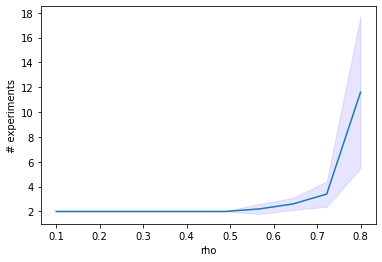

In [28]:
plot_rho_significance(rhos, ys, ci)

## Comparisons

In [29]:
def plot_boxplot_data(data, labels):

    plt.boxplot(data, labels=labels)
    plt.ylabel("Average waiting time")
    plt.show()

def print_all_p_values(data):

    for i in range(len(data)):
        for j in range(i):

            print(f"p-value of data {i} against {j}: {calc_pvalue(data[i], data[j])}")

### M/M/n comparisons

In [30]:
def calculate_compare_mmn_data(rho, lamda, nruns):

    data1 = generate_data(rho, lamda, 1, nruns)
    data2 = generate_data(rho, lamda, 2, nruns)
    data4 = generate_data(rho, lamda, 4, nruns)

    return data1, data2, data4

In [31]:
MAX_SIM_TIME = 10000
compare_mmn_data = calculate_compare_mmn_data(0.7, 1, 20)

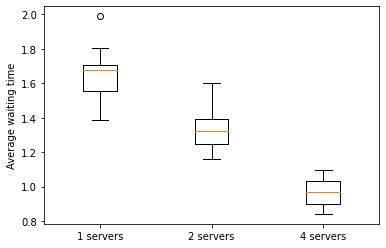

p-value of data 1 against 0: 1.45966875718839e-09
p-value of data 2 against 0: 4.490864521931244e-21
p-value of data 2 against 1: 4.444214431199664e-14


In [32]:
plot_boxplot_data(compare_mmn_data, ["1 servers", "2 servers", "4 servers"])
print_all_p_values(compare_mmn_data)

### FIFO vs shortest job

In [33]:
def calc_compare_FIFO_vs_shortest_job_data(rho, lamda, nruns):
    
    data1 = generate_data(rho, lamda, 1, nruns, shortest_job_first=True)
    data2 = generate_data(rho, lamda, 1, nruns, shortest_job_first=False)

    return data1, data2

In [35]:
MAX_SIM_TIME = 10000
compare_FIFO_vs_shortest_job_data = calc_compare_FIFO_vs_shortest_job_data(0.7, 1, 20)

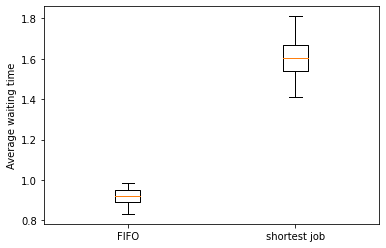

p-value of data 1 against 0: 3.561048094723617e-26


In [34]:
plot_boxplot_data(compare_FIFO_vs_shortest_job_data, ["FIFO", "shortest job"])
print_all_p_values(compare_FIFO_vs_shortest_job_data)